# EXPLORATORY DATA ANALYSIS

## Loading & First exploration

This section is a preliminatory datasets exploration, in order to have a first idea of the four datasets, to look for any missing values and outliers.

### Preliminary loading 

In [26]:
#Loading the necessary packages
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy import stats
from sklearn.model_selection import train_test_split

In [27]:
#Loading the datasets
df_airport = pd.read_csv("Raw_data/training_set_airport_data.csv")
df_geographic = pd.read_csv("Prepared_data/new_geographic_data.csv", sep = ";")
df_weather = pd.read_csv("Raw_data/Weather_data/weather_data_train_set.csv")
df_aircraft = pd.read_csv("Prepared_data/ACchar.csv", sep = ";")

/Users/evafrancois/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### EDA of the training set airport data

In [270]:
#Rename the columns
df_airport.rename(columns={'Flight Datetime':'flight_dt',
                          'Aircraft Model':'aircraft_model'}, 
                 inplace=True)

In [271]:
df_airport.describe()

flight_dt aircraft_model           AOBT             ATOT  \
count          543813         543813         543813           543813   
unique         244764            143         461674           538720   
top     4/2/2016 5:00           A319  9/4/2015 5:54  8/29/2015 13:40   
freq                9         178048              5                3   

           Stand    Runway  
count     543813    543813  
unique       166         4  
top     STAND_61  RUNWAY_2  
freq        3453    136375

In [272]:
#Convert date string into date format
df_airport['flight_dt'] =  pd.to_datetime(df_airport['flight_dt'], format='%m/%d/%Y %H:%M')
df_airport['AOBT'] =  pd.to_datetime(df_airport['AOBT'], format='%m/%d/%Y %H:%M')
df_airport['ATOT'] =  pd.to_datetime(df_airport['ATOT'], format='%m/%d/%Y %H:%M')
df_airport.head()

flight_dt     aircraft_model                AOBT  \
0 2015-01-01 06:00:00  B737-800 WINGLETS 2015-01-01 05:56:00   
1 2015-01-01 06:10:00       A320-100/200 2015-01-01 06:08:00   
2 2015-01-01 06:15:00       A320-100/200 2015-01-01 06:08:00   
3 2015-01-01 06:20:00       A320-100/200 2015-01-01 06:24:00   
4 2015-01-01 06:20:00               A319 2015-01-01 06:14:00   

                 ATOT      Stand    Runway  
0 2015-01-01 06:05:00   STAND_62  RUNWAY_4  
1 2015-01-01 06:18:00  STAND_153  RUNWAY_4  
2 2015-01-01 06:19:00   STAND_44  RUNWAY_2  
3 2015-01-01 06:36:00    STAND_7  RUNWAY_3  
4 2015-01-01 06:27:00   STAND_17  RUNWAY_2

In [273]:
# Create a function that computes the TaxiTime in minutes
def DatetimeToTaxitime(datetime1, datetime2):
    difference = datetime2 - datetime1
    taxitime = difference.value / 6e10
    return taxitime

# Compute the taxitime in the airport dataframe 
df_airport['taxitime'] = df_airport.apply(lambda x: DatetimeToTaxitime(x.AOBT, x.ATOT), axis =1)

In [274]:
len(df_airport)

543813

In [275]:
df_airport.describe()

taxitime
count  543813.000000
mean       18.754785
std         8.172083
min      -218.000000
25%        14.000000
50%        18.000000
75%        22.000000
max       656.000000

In [276]:
#NA search: No NA to clean
df_airport.isnull().sum()

flight_dt         0
aircraft_model    0
AOBT              0
ATOT              0
Stand             0
Runway            0
taxitime          0
dtype: int64

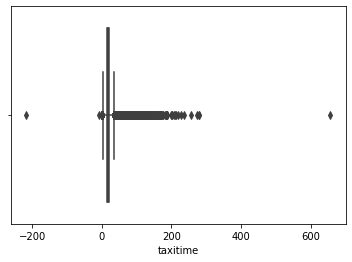

In [277]:
#Outliers search - there seems to some outliers 
# For some outiliers the ATOT is before the AOBT: there is a mistake so we should delete them
# For the others, we will see a strategy to handle the outliers in the data preparation section
ax = sns.boxplot(df_airport["taxitime"])

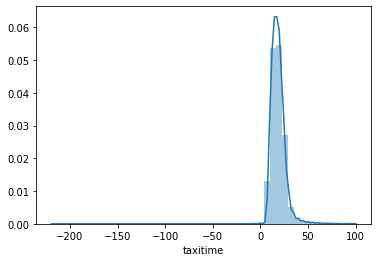

In [278]:
#We observe a quasi normal distribution
sns.distplot(df_airport[df_airport["taxitime"] <100].taxitime)

### EDA of the geographic dataset

In [279]:
df_geographic.head()

runway_stand  Lat_runway  Lng_runway  Lat_stand  Lng_stand
0    RUNWAY_1STAND_1   54.755307    -0.02304  54.764575   0.000356
1   RUNWAY_1STAND_10   54.755307    -0.02304  54.764382  -0.001061
2  RUNWAY_1STAND_100   54.755307    -0.02304  54.766471   0.018516
3  RUNWAY_1STAND_101   54.755307    -0.02304  54.770003   0.020513
4  RUNWAY_1STAND_102   54.755307    -0.02304  54.769606   0.018924

In [280]:
# Create the functions that compute distance between runways & stands in kilometers
def degreesToRadians(degrees):
    return degrees * np.pi / 180

def distanceInMBetweenCoordinates(lat1, lon1, lat2, lon2):
    earthRadiusKm = 6371;

    dLat = degreesToRadians(lat2-lat1)
    dLon = degreesToRadians(lon2-lon1)

    lat1 = degreesToRadians(lat1)
    lat2 = degreesToRadians(lat2)

    calculation = np.sin(dLat/2) * np.sin(dLat/2) + np.sin(dLon/2) * np.sin(dLon/2) * np.cos(lat1) * np.cos(lat2) 
    distance = 2 * math.atan2(np.sqrt(calculation), np.sqrt(1-calculation)) 
    return earthRadiusKm * distance * 1000

In [281]:
# Compute the distance in the aircraft dataframe
df_geographic['distance'] = df_geographic.apply(lambda x: distanceInMBetweenCoordinates(x.Lat_runway, x.Lng_runway, x.Lat_stand, x.Lng_stand), axis =1)

In [282]:
df_geographic.describe()

Lat_runway  Lng_runway   Lat_stand   Lng_stand     distance
count  664.000000  664.000000  664.000000  664.000000   664.000000
mean    54.758773   -0.004747   54.767037    0.009493  1730.470344
std      0.002643    0.019280    0.003191    0.009616   897.514890
min     54.755307   -0.024107   54.761081   -0.009674   158.869217
25%     54.756667   -0.023307   54.764575    0.003887   992.633820
50%     54.759147   -0.007360   54.766618    0.009772  1461.000769
75%     54.761253    0.011200   54.769606    0.018498  2578.251494
max     54.761493    0.019840   54.773947    0.026379  3321.122245

In [283]:
#NA search: No NA to clean
df_geographic.isnull().sum()

runway_stand    0
Lat_runway      0
Lng_runway      0
Lat_stand       0
Lng_stand       0
distance        0
dtype: int64

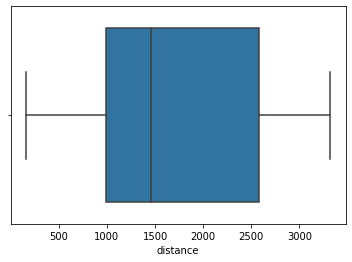

In [284]:
#Outliers search - there seems to be no outlier 
ax = sns.boxplot(df_geographic["distance"])

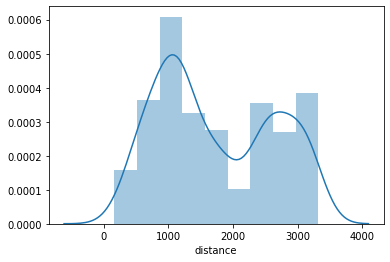

In [285]:
sns.distplot(df_geographic["distance"])

In [286]:
df_geographic = df_geographic[['runway_stand', 'distance']]

### EDA of the weather dataset

In [287]:
df_weather.head()

time_hourly        summary                 icon  precipIntensity  \
0  1/1/2015 6:00  Mostly Cloudy  partly-cloudy-night              0.0   
1  1/1/2015 6:00  Mostly Cloudy  partly-cloudy-night              0.0   
2  1/1/2015 6:00  Mostly Cloudy  partly-cloudy-night              0.0   
3  1/1/2015 6:00  Mostly Cloudy  partly-cloudy-night              0.0   
4  1/1/2015 6:00  Mostly Cloudy  partly-cloudy-night              0.0   

   precipProbability  temperature  apparentTemperature  dewPoint  humidity  \
0                0.0        44.65                39.29      42.8      0.93   
1                0.0        44.65                39.29      42.8      0.93   
2                0.0        44.65                39.29      42.8      0.93   
3                0.0        44.65                39.29      42.8      0.93   
4                0.0        44.65                39.29      42.8      0.93   

   pressure  windSpeed  windGust  windBearing  cloudCover  uvIndex  \
0    1031.6      10.29     11.39        210.0        0.75      0.0   
1    1031.6      10.29     11.39        210.0        0.75      0.0   
2    1031.6      10.29     11.39        210.0        0.75      0.0   
3    1031.6      10.29     11.39        210.0        0.75      0.0   
4    1031.6      10.29     11.39        210.0        0.75      0.0   

   visibility precipType  precipAccumulation  ozone  
0       5.859       None                 0.0  310.4  
1       5.859       None                 0.0  310.4  
2       5.859       None                 0.0  310.4  
3       5.859       None                 0.0  310.4  
4       5.859       None                 0.0  310.4

In [288]:
#Convert date string into date format
df_weather['time_hourly'] =  pd.to_datetime(df_weather['time_hourly'], format='%m/%d/%Y %H:%M')

In [289]:
#Rename the columns
df_weather.rename(columns={'time_hourly':'AOBT_hourly'}, 
                 inplace=True)

#Create hourly AOBT in airport data to join with weather data

def hour_rounder(t):
    # Rounds to nearest hour by adding a timedelta hour if minute >= 30
    return (t.replace(second=0, microsecond=0, minute=0, hour=t.hour)
               +timedelta(hours=t.minute//30))

# Compute the distance in the aircraft dataframe
df_airport['AOBT_hourly'] = df_airport.apply(lambda x: hour_rounder(x.AOBT), axis =1)

In [290]:
df_weather = df_weather.drop_duplicates()

In [291]:
df_weather.describe()

precipIntensity  precipProbability   temperature  apparentTemperature  \
count     29481.000000       29481.000000  33823.000000         33823.000000   
mean          0.001401           0.037940     53.261394            51.952420   
std           0.008215           0.146128     10.985435            12.514141   
min           0.000000           0.000000     17.670000            10.380000   
25%           0.000000           0.000000     45.600000            42.150000   
50%           0.000000           0.000000     52.620000            52.620000   
75%           0.000000           0.000000     60.860000            60.860000   
max           0.332800           1.000000     93.510000            96.700000   

           dewPoint      humidity      pressure     windSpeed      windGust  \
count  33824.000000  33823.000000  29406.000000  33807.000000  30218.000000   
mean      46.217615      0.788989   1015.562310      7.551346     10.969000   
std        9.080322      0.154517     10.608472      4.600294      7.991617   
min       12.190000      0.250000    971.700000      0.000000      0.000000   
25%       39.220000      0.680000   1009.600000      4.690000      5.660000   
50%       46.410000      0.820000   1016.700000      6.930000      9.180000   
75%       53.590000      0.930000   1022.600000     10.290000     14.050000   
max       69.450000      1.000000   1045.700000     33.120000     51.310000   

        windBearing    cloudCover       uvIndex    visibility  \
count  32959.000000  32878.000000  33264.000000  33799.000000   
mean     195.557845      0.519742      1.183862      6.097705   
std       93.995074      0.294911      1.790903      1.502209   
min        0.000000      0.000000      0.000000      0.031000   
25%      124.000000      0.190000      0.000000      6.216000   
50%      220.000000      0.480000      0.000000      6.216000   
75%      260.000000      0.750000      2.000000      6.216000   
max      359.000000      1.000000      9.000000     10.000000   

       precipAccumulation         ozone  
count        33824.000000  33824.000000  
mean             0.000012    314.011761  
std              0.000992     21.054959  
min              0.000000    212.500000  
25%              0.000000    310.400000  
50%              0.000000    310.400000  
75%              0.000000    310.400000  
max              0.137400    480.000000

### EDA of the aircraft dataset

In [ ]:
df_aircraft.head()

In [ ]:
len(df_aircraft)

## Data analysis

### Combining all datasets

In [292]:
#Let's combine our training set with the aircraft dataset (the key is the model)
df_train = pd.merge(df_airport, df_aircraft ,on='aircraft_model',how='left')

#Let's combine our training set with the geographic dataset (the key is the runway & the stand)
df_train['runway_stand'] = df_train['Runway'] + df_train['Stand']
df_train = pd.merge(df_train, df_geographic ,on='runway_stand',how='left')

#Let's combine our training set with the weather dataset (the key is the datetime)
df_train = pd.merge(df_train, df_weather ,on = 'AOBT_hourly', how='left')

In [36]:
len(df_train)

543813

### Correlation analysis

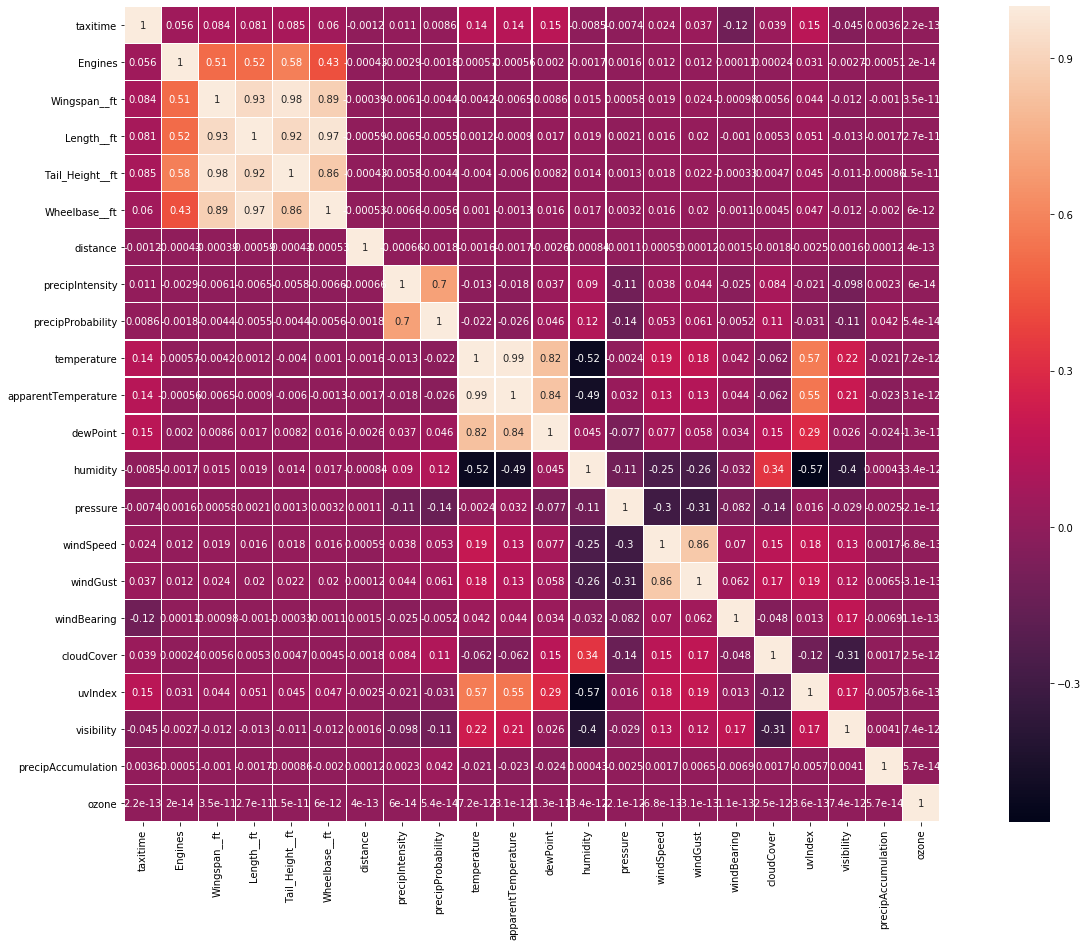

In [47]:
#Display the correlation matrix between the variables 
base_correlation = df_train.drop(['flight_dt', 'AOBT', 'ATOT', 'AOBT_hourly'], axis=1)
corrMatrix = base_correlation.corr()
plt.figure(figsize = (25,15))
sns.heatmap(corrMatrix, annot=True, square=True, linewidths=.3)

# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show()

/Users/evafrancois/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/evafrancois/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


<Figure size 1008x1008 with 0 Axes>

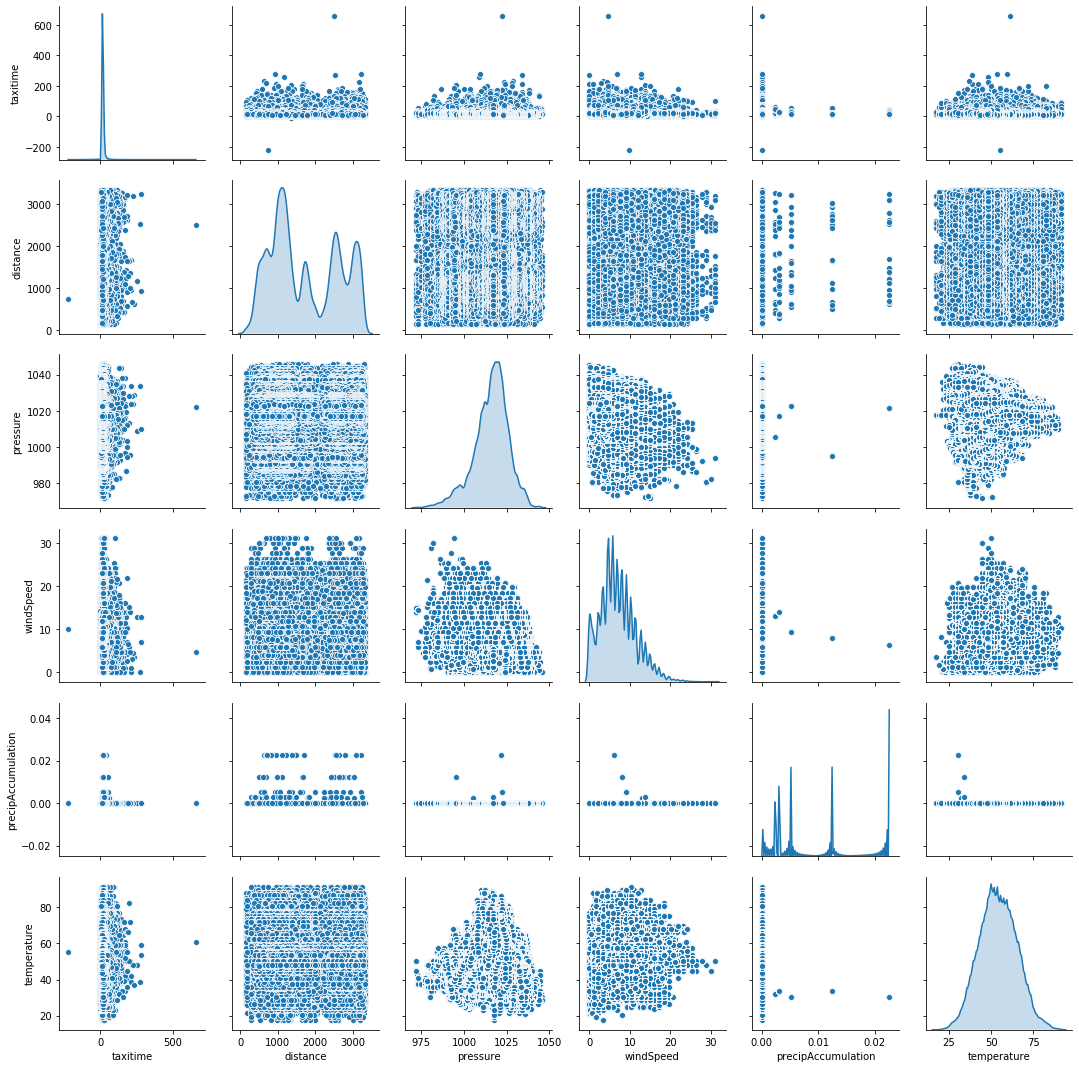

In [32]:
base_pairplot = df_train[['taxitime', 'distance', 'pressure', 'windSpeed', 'precipAccumulation', 'temperature']]
plt.figure(figsize=(14, 14))

sns.pairplot(base_pairplot, diag_kind='kde')

# DATA PREPARATION

This section is dedicated to the preprocessing of our datasets 

## Data cleaning

### Missing values cleaning

In [293]:
df_train.isnull().sum()

flight_dt                  0
aircraft_model             0
AOBT                       0
ATOT                       0
Stand                      0
Runway                     0
taxitime                   0
AOBT_hourly                0
Manufacturer              38
Engines                   38
Wingspan__ft              38
Length__ft                38
Tail_Height__ft           38
Wheelbase__ft             38
Wake_Category             38
runway_stand               0
distance                   0
summary                91918
icon                   91918
precipIntensity        89356
precipProbability      89356
temperature             2423
apparentTemperature     2423
dewPoint                2395
humidity                2423
pressure               90838
windSpeed               2739
windGust               74419
windBearing            20471
cloudCover             21218
uvIndex                15102
visibility              2857
precipType              2395
precipAccumulation      2395
ozone         

In [294]:
#We can drop the missing values for all the column where they correspond to delete (because less than 1% of the huge dataset)
subset_delete = ['Manufacturer', 'Engines', 'Wingspan__ft', 'Length__ft', 'Tail_Height__ft', 
                'Wheelbase__ft', 'Wake_Category', 'temperature', 'apparentTemperature', 'dewPoint', 'humidity',
                'windSpeed', 'visibility', 'precipType', 'precipAccumulation', 'ozone']
df_train = df_train.dropna(subset = subset_delete)

In [295]:
#For the remaining NAs value (weather data), 
#we are going to use the method fillna assuming that the weather does not change as much from one hour to another
df_train = df_train.fillna(method='ffill')

### Deal with the outliers of taxitime

In [123]:
#From the EDA and the Outliers search for the variable to predict - there seems to be some outliers 
# For some outiliers the ATOT is before the AOBT: there is a mistake so we should delete them

#Delete the taxitime < 0 (we assume that there is a mistake)
df_train = df_train[df_train["taxitime"] > 0]



In [297]:
# For the others, we will use Z-score strategy to identify Data point that falls outside of 3 standard deviations 
z_score = np.abs(stats.zscore(df_train.taxitime))
threshold = 3
outliers = df_train[(z_score > 3)]

In [298]:
#We observe that all the outliers correspond to specific aircraft model that have taxitime > 45 in average
# We will keep these outliers and point them thanks to a new variable: the historical average taxitime per aircraft model
outliers[['aircraft_model', 'taxitime']].groupby("aircraft_model").mean()

taxitime
aircraft_model                
100                  50.000000
A310-300             52.000000
A319                 61.047384
A320 NEO             44.000000
A320-100/200         61.069173
A321-100/200         59.550725
A330-200             58.700000
A330-300             59.307692
A340-300             50.000000
A350-900             50.000000
A380-800             54.833333
AN-124 Ruslan        45.000000
ATR 72-500           66.250000
B737-300             71.000000
B737-300 Freighter   55.500000
B737-400             72.000000
B737-700             62.000000
B737-700 WINGLETS    60.181818
B737-8 MAX           49.000000
B737-800             45.000000
B737-800 WINGLETS    59.143075
B737-900ER           52.000000
B747-400 Passenger   61.277778
B757-200 Passenger   62.285714
B757-200 WINGLETS    62.721154
B767-300ER           67.000000
B777-200             57.234375
B777-300ER           67.333333
B787-800 Dreamliner  50.386364
B787-900             52.052632
BD500 1A10           47.000000
BOMBARDIER CS300     48.333333
DASH 8-Q400          55.000000
EMB-135              56.000000
EMB-145              66.000000
EMB-170              57.000000
EMBRAER E75          65.000000
ERJ-190              59.857143
ERJ-195              54.444444
G V                  71.500000
MD-82                87.000000

## Features engineering

### Computing log(distance)

In [299]:
#Compute log(distance)
df_train['log_distance'] = np.log(df_train['distance'])

### Computing Q and N

In [300]:
## Compute Q & N variables (amount of traffic on the airplace surface) 
import time

#Checking if a date is in the interval [date1,date2]
def CheckDateInInterval(date,date1,date2):
    if date >= date1 and date2 >= date:
        return 1
    else:
        return 0

#Initializing N & Q list
Q_list = []
N_list = []

#Creating one list of all AOBTs and one list of all ATOTs
interval_list1 = list(df_train['AOBT'])
interval_list2 = list(df_train['ATOT'])

start_time = time.time()

#We take as a window the number of Stands in the airport (166)
# Here we assume at most, there is as much airplanes in taxitime at the same time than the number of stands 
window = len(df_train['Stand'].unique())

for row in range(len(df_train)):
    #Setting the AOBT and ATOT of a given row
    AOBT = interval_list1[row]
    ATOT = interval_list2[row]
    
    #Defining the min and max rows in the dataframe this iteration will have to consider
    min_row = max(0, row - window)
    max_row = min(row + window, len(df_train))
    
    short_list1 = interval_list1[min_row : max_row]
    short_list2 = interval_list2[min_row : max_row]
    
    #Creating a list of Booleans where there is 1 if for this iteration the row meets the condition for N
    N_boolean = map(lambda x, y : CheckDateInInterval(AOBT, x, y), short_list1, short_list2)
    #Computing the sum of the airplane satisfying the condition for N
    N_number = max(sum(list(N_boolean))-1, 0)
    N_list.append(N_number)

    #Creating a list of Booleans where there is 1 if for this iteration the row meets the condition for Q
    Q_boolean = map(lambda y : CheckDateInInterval(y, AOBT, ATOT), short_list2)
    #Computing the sum of the airplane satisfying the condition for Q
    Q_number = max(0, sum(list(Q_boolean))-1)
    Q_list.append(Q_number)
    
    if row % 50000 == 0:
        running_time = time.time() - start_time
        print("Row number: ", row, "/ Running time: " , running_time)

df_train['N'] = N_list        
df_train['Q'] = Q_list

Row number:  0 / Running time:  0.028812170028686523
Row number:  50000 / Running time:  12.145375967025757
Row number:  100000 / Running time:  24.664536237716675
Row number:  150000 / Running time:  35.74834609031677
Row number:  200000 / Running time:  46.828449010849
Row number:  250000 / Running time:  58.32212018966675
Row number:  300000 / Running time:  70.64069199562073
Row number:  350000 / Running time:  83.27065920829773
Row number:  400000 / Running time:  95.0005202293396
Row number:  450000 / Running time:  107.53872418403625
Row number:  500000 / Running time:  123.81121921539307


### Converting Date data

In [302]:
pi = np.pi


def date_transfo(df):
#Transform Date into several column
    df['hour'] = df['AOBT'].dt.hour
    df['month'] = df['AOBT'].dt.month
    df['quarter'] = df['AOBT'].dt.quarter
    
    #Where average taxitime < 15 mins
    df_train['off-peak_hour'] = ((df_train['hour'] <4) + (df_train['hour'] >21 ))*1
    
    # Get circular hour
    df['hour_sin'] = np.sin(pi* df['hour'].astype(np.float64) /12)
    df['hour_cos'] = np.cos(pi* df['hour'].astype(np.float64) /12)
    df['month_sin'] = np.sin(pi* df['month'].astype(np.float64) /6)
    df['month_cos'] = np.cos(pi* df['month'].astype(np.float64) /6)
    df['quarter_sin'] = np.sin(pi* df['quarter'].astype(np.float64) /2)
    df['quarter_cos'] = np.cos(pi* df['quarter'].astype(np.float64) /2)

    return(df)

df_train = date_transfo(df_train)

/Users/evafrancois/opt/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:194: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  op=op_str, alt_op=unsupported[op_str]


### Converting categorical variables

In [303]:
df_train = df_train.join(pd.get_dummies(df_train['icon'], prefix='i'))

df_train = df_train.join(pd.get_dummies(df_train['precipType'], prefix='pt'))

#For the Wake Category, we are going to use Label Encoder as there is a linear combination between the wake and the taxitime
df_train = df_train.replace({'L': 1, 'M': 2, 'H': 3})

In [308]:
#Features per aircrafts
avg_aircraft = df_train[['aircraft_model', 'taxitime']].groupby('aircraft_model').mean()

avg_aircraft.rename(columns={'taxitime':'aircraft_taxitime'}, 
                 inplace=True)

df_train = pd.merge(df_train, avg_aircraft ,on='aircraft_model',how='left')


In [ ]:
#Delete useless columns
df_train = df_train.drop(['flight_dt', 'ATOT', 'AOBT_hourly', 
                         'Lat_runway', 'Lng_runway', 'Lat_stand', 'Lng_stand'], axis = 1)

In [310]:
#Download the new dataset cleaned in local
df_train.to_csv('clean_training_set_vf.csv.zip', index=False,
          compression='gzip')